In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil

import cv2
import random
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
#from ml_dtypes import float8_e4m3b11
from ml_dtypes import float8_e4m3b11fnuz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter
from PIL import Image
from keras.layers import Input,Conv2D, MaxPooling2D, UpSampling2D, Concatenate,Conv2DTranspose
from keras.layers import concatenate
from keras.metrics import Accuracy, Precision, Recall
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import f1_score
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")
import glob

from sklearn.model_selection import train_test_split

#pip install --user tensorflow==2.15.0
#pip install --upgrade tensorflow
#pip install --upgrade ml_dtypes

In [2]:
#IMAGE_SIZE = (128, 128)

In [3]:

# Get the current working directory
current_directory = os.getcwd()

# Specify the correct path based on the directory structure
DIRECTORY = os.path.join(current_directory, "Dataset_BUSI_with_GT")
CATEGORIES = ['benign', 'malignant', 'normal']

# # Specify the correct path based on the directory structure
# DIRECTORY = "KDD\Project4\Dataset_BUSI_with_GT"
# CATEGORIES = ['benign', 'malignant', 'normal']

# Create lists to store data
file_paths = []
class_labels = []

# Loop through each category
for category in CATEGORIES:
    category_path = os.path.join(DIRECTORY, category)
    
    # Loop through each image in the category folder
    for filename in os.listdir(category_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Adjust file extensions as needed
            file_path = os.path.join(category_path, filename)
            
            # Store file path and corresponding class label
            file_paths.append(file_path)
            class_labels.append(category)

# Create DataFrame
data = {'File Path': file_paths, 'Class Label': class_labels}
df = pd.DataFrame(data)

# Display the DataFrame
print(df.head())

# # Check the total number of rows in the DataFrame
# total_rows = df.shape[0]

# # Print the total number of rows
# print("Total Rows in DataFrame:", total_rows)

                                           File Path Class Label
0  c:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_...      benign
1  c:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_...      benign
2  c:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_...      benign
3  c:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_...      benign
4  c:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_...      benign


In [4]:
#print(os.getcwd())

In [5]:
# Divide the dataset into training (40%) and testing (60%) sets
train_df, test_df = train_test_split(df, test_size=0.6, random_state=42)

# Display the size of the training and testing sets
print("Training set size:", len(train_df))
print("Testing set size:", len(test_df))

print(train_df.head())

Training set size: 631
Testing set size: 947
                                              File Path Class Label
7     c:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_...      benign
962   c:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_...   malignant
667   c:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_...      benign
1220  c:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_...   malignant
357   c:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_...      benign


In [6]:
#unsupervised learning
# Load VGG16 model pre-trained on ImageNet data
model = VGG16(weights='imagenet', include_top=False)

# Function to extract features using VGG16
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array)
    features = features.flatten()
    return features

# Add VGG16 features to the DataFrame
train_df['VGG16 Features'] = train_df['File Path'].apply(extract_features)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)  # You can adjust the number of components
vgg16_pca = pca.fit_transform(np.vstack(train_df['VGG16 Features']))

# Standardize the PCA components
scaler = StandardScaler()
vgg16_pca_standardized = scaler.fit_transform(vgg16_pca)

# Add standardized PCA components to the DataFrame
for i in range(vgg16_pca_standardized.shape[1]):
    train_df[f'PCA_{i+1}_Standardized'] = vgg16_pca_standardized[:, i]

# Apply clustering (KMeans) on the standardized PCA features
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust the number of clusters
train_df['Cluster'] = kmeans.fit_predict(vgg16_pca_standardized)

# Display the updated DataFrame
print(train_df.head())


1/1 [==============================] - 0s 151ms/step
                                              File Path Class Label  \
7     c:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_...      benign   
962   c:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_...   malignant   
667   c:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_...      benign   
1220  c:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_...   malignant   
357   c:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_...      benign   

                                         VGG16 Features  PCA_1_Standardized  \
7     [0.0, 0.0, 0.0, 0.0, 0.0, 1.2838473, 0.0, 0.0,...           -1.023489   
962   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...            0.981865   
667   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...           -0.865809   
1220  [0.0, 0.0, 0.0, 22.998842, 0.0, 0.0, 0.0, 0.0,...           -0.562996   
357   [0.0, 0.0, 9.998649, 0.0, 5.295947, 1.2620867,...           -0.973513   

      PCA_2_Standardized  PCA_3_Standardized

In [7]:
# # Divide the dataset into training (40%) and testing (60%) sets
# train_df, test_df = train_test_split(df, test_size=0.6, random_state=42)

# # Display the size of the training and testing sets
# print("Training set size:", len(train_df))
# print("Testing set size:", len(test_df))

print(train_df.head())

                                              File Path Class Label  \
7     c:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_...      benign   
962   c:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_...   malignant   
667   c:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_...      benign   
1220  c:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_...   malignant   
357   c:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_...      benign   

                                         VGG16 Features  PCA_1_Standardized  \
7     [0.0, 0.0, 0.0, 0.0, 0.0, 1.2838473, 0.0, 0.0,...           -1.023489   
962   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...            0.981865   
667   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...           -0.865809   
1220  [0.0, 0.0, 0.0, 22.998842, 0.0, 0.0, 0.0, 0.0,...           -0.562996   
357   [0.0, 0.0, 9.998649, 0.0, 5.295947, 1.2620867,...           -0.973513   

      PCA_2_Standardized  PCA_3_Standardized  PCA_4_Standardized  \
7              -0.024433      

# Task 4


In [8]:
# Data Cleaning Steps:
# - Check for missing values
# - Identify and handle outliers
# - Remove duplicate entries

# Check for missing values
missing_values = train_df.isnull().sum()
print("Missing values:\n", missing_values)

# Handle outliers (if any)
# For example, you can use z-score or other techniques to identify and handle outliers.

# Convert NumPy arrays to tuples
train_df['VGG16 Features'] = train_df['VGG16 Features'].apply(tuple)

# Drop duplicates
train_df = train_df.drop_duplicates()

# Display the size of the dataset after data cleaning
print("Dataset size after cleaning:", len(train_df))


Missing values:
 File Path              0
Class Label            0
VGG16 Features         0
PCA_1_Standardized     0
PCA_2_Standardized     0
PCA_3_Standardized     0
PCA_4_Standardized     0
PCA_5_Standardized     0
PCA_6_Standardized     0
PCA_7_Standardized     0
PCA_8_Standardized     0
PCA_9_Standardized     0
PCA_10_Standardized    0
PCA_11_Standardized    0
PCA_12_Standardized    0
PCA_13_Standardized    0
PCA_14_Standardized    0
PCA_15_Standardized    0
PCA_16_Standardized    0
PCA_17_Standardized    0
PCA_18_Standardized    0
PCA_19_Standardized    0
PCA_20_Standardized    0
PCA_21_Standardized    0
PCA_22_Standardized    0
PCA_23_Standardized    0
PCA_24_Standardized    0
PCA_25_Standardized    0
PCA_26_Standardized    0
PCA_27_Standardized    0
PCA_28_Standardized    0
PCA_29_Standardized    0
PCA_30_Standardized    0
PCA_31_Standardized    0
PCA_32_Standardized    0
PCA_33_Standardized    0
PCA_34_Standardized    0
PCA_35_Standardized    0
PCA_36_Standardized    0
PCA_37_S

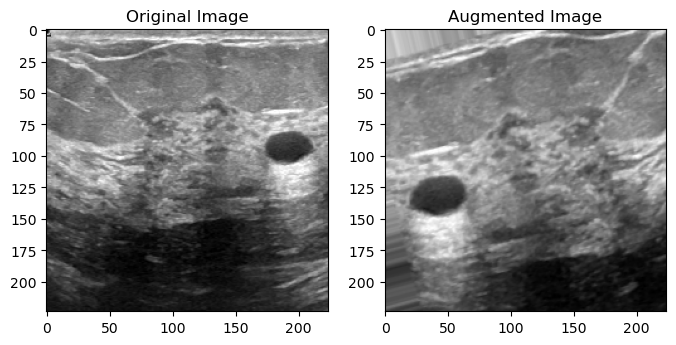

In [9]:
#data transformation

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Get the current working directory
# current_directory = os.getcwd()

# # Specify the correct path based on the directory structure
# DIRECTORY = os.path.join(current_directory, "Dataset_BUSI_with_GT")
# CATEGORIES = ['benign', 'malignant', 'normal']

# # Create lists to store data
# file_paths = []
# class_labels = []

# # Loop through each category
# for category in CATEGORIES:
#     category_path = os.path.join(DIRECTORY, category)
    
#     # Loop through each image in the category folder
#     for filename in os.listdir(category_path):
#         if filename.endswith(('.jpg', '.jpeg', '.png')):  # Adjust file extensions as needed
#             file_path = os.path.join(category_path, filename)
            
#             # Store file path and corresponding class label
#             file_paths.append(file_path)
#             class_labels.append(category)

# # Create DataFrame
# data = {'File Path': file_paths, 'Class Label': class_labels}
# df = pd.DataFrame(data)

# Load an example image before transformation
img_path = train_df['File Path'].iloc[0]
img = image.load_img(img_path, target_size=(224, 224))

# Display the original image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

# Apply transformations using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Convert the image to a NumPy array and expand dimensions
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Generate augmented images
augmented_images = datagen.flow(img_array, batch_size=1)

# Get the first augmented image
augmented_img = augmented_images[0][0]

# Display the augmented image
plt.subplot(1, 2, 2)
plt.imshow(augmented_img.astype('uint8'))  # Ensure pixel values are in the correct range
plt.title('Augmented Image')

plt.show()




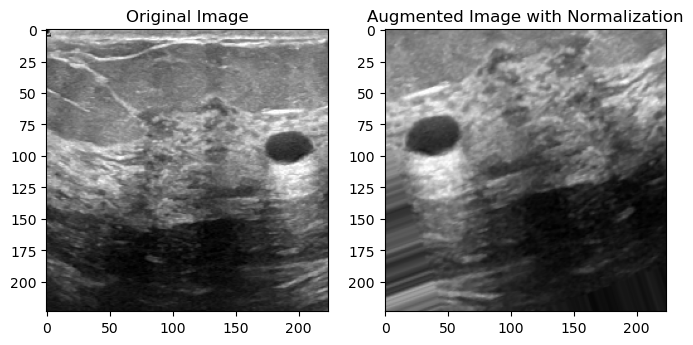

In [10]:
#Data Normalization
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Get the current working directory
# current_directory = os.getcwd()

# # Specify the correct path based on the directory structure
# DIRECTORY = os.path.join(current_directory, "Dataset_BUSI_with_GT")
# CATEGORIES = ['benign', 'malignant', 'normal']

# # Create lists to store data
# file_paths = []
# class_labels = []

# # Loop through each category
# for category in CATEGORIES:
#     category_path = os.path.join(DIRECTORY, category)
    
#     # Loop through each image in the category folder
#     for filename in os.listdir(category_path):
#         if filename.endswith(('.jpg', '.jpeg', '.png')):  # Adjust file extensions as needed
#             file_path = os.path.join(category_path, filename)
            
#             # Store file path and corresponding class label
#             file_paths.append(file_path)
#             class_labels.append(category)

# # Create DataFrame
# data = {'File Path': file_paths, 'Class Label': class_labels}
# df = pd.DataFrame(data)

# Load an example image before normalization
img_path = train_df['File Path'].iloc[0]
img = image.load_img(img_path, target_size=(224, 224))

# Display the original image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

# Apply transformations using ImageDataGenerator (including normalization)
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to be between 0 and 1
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Convert the image to a NumPy array and expand dimensions
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Generate augmented images (including normalization)
augmented_images = datagen.flow(img_array, batch_size=1)

# Get the first augmented image
augmented_img = augmented_images[0][0]

# Display the augmented image
plt.subplot(1, 2, 2)
plt.imshow(augmented_img)  # No need to convert to uint8 after normalization
plt.title('Augmented Image with Normalization')

plt.show()


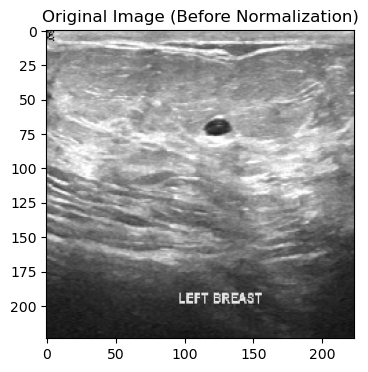

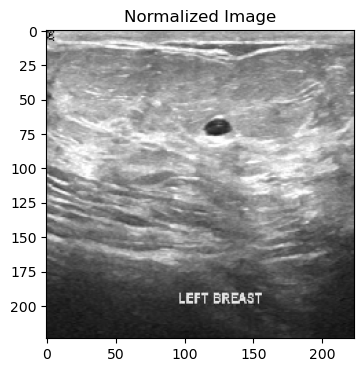

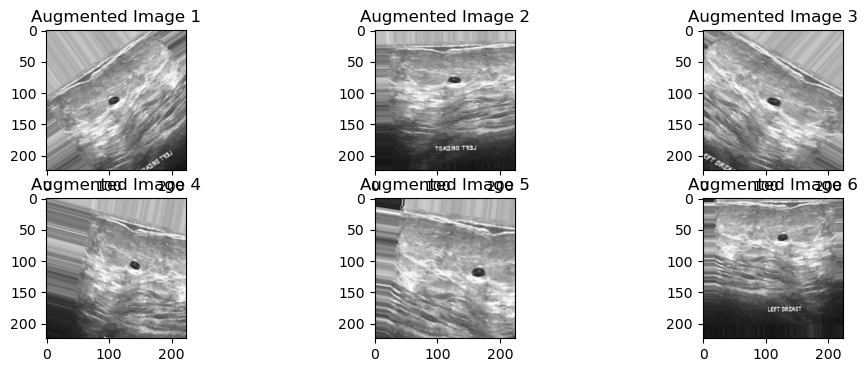

In [11]:
#Specific Data Type Processing:
# Specify the correct path based on the directory structure
DIRECTORY = os.path.join(current_directory, "Dataset_BUSI_with_GT")
CATEGORIES = ['benign', 'malignant', 'normal']

# Create lists to store data
file_paths = []
class_labels = []

# Loop through each category
for category in CATEGORIES:
    category_path = os.path.join(DIRECTORY, category)
    
    # Loop through each image in the category folder
    for filename in os.listdir(category_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Adjust file extensions as needed
            file_path = os.path.join(category_path, filename)
            
            # Store file path and corresponding class label
            file_paths.append(file_path)
            class_labels.append(category)

# Create DataFrame
data = {'File Path': file_paths, 'Class Label': class_labels}
df = pd.DataFrame(data)

# Load an example image before normalization
img_path = df['File Path'].iloc[0]
img = image.load_img(img_path, target_size=(224, 224))
img_array_before = image.img_to_array(img)

# Display the original image before normalization
plt.figure(figsize=(4, 4))
plt.imshow(img_array_before / 255.0)  # Normalize pixel values to [0, 1]
plt.title('Original Image (Before Normalization)')
plt.show()

# Image normalization
img_array_normalized = img_array_before / 255.0

# Display the normalized image
plt.figure(figsize=(4, 4))
plt.imshow(img_array_normalized)
plt.title('Normalized Image')
plt.show()

# Image augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Reshape the image for augmentation
img_array_reshaped = img_array_normalized.reshape((1,) + img_array_normalized.shape)

# Generate augmented images
augmented_images = datagen.flow(img_array_reshaped, batch_size=1)

# Display augmented images
plt.figure(figsize=(12, 4))
for i in range(6):
    augmented_img = augmented_images.next()[0]
    plt.subplot(2, 3, i+1)
    plt.imshow(augmented_img)
    plt.title(f'Augmented Image {i+1}')

plt.show()

In [12]:
print(train_df.columns)

Index(['File Path', 'Class Label', 'VGG16 Features', 'PCA_1_Standardized',
       'PCA_2_Standardized', 'PCA_3_Standardized', 'PCA_4_Standardized',
       'PCA_5_Standardized', 'PCA_6_Standardized', 'PCA_7_Standardized',
       'PCA_8_Standardized', 'PCA_9_Standardized', 'PCA_10_Standardized',
       'PCA_11_Standardized', 'PCA_12_Standardized', 'PCA_13_Standardized',
       'PCA_14_Standardized', 'PCA_15_Standardized', 'PCA_16_Standardized',
       'PCA_17_Standardized', 'PCA_18_Standardized', 'PCA_19_Standardized',
       'PCA_20_Standardized', 'PCA_21_Standardized', 'PCA_22_Standardized',
       'PCA_23_Standardized', 'PCA_24_Standardized', 'PCA_25_Standardized',
       'PCA_26_Standardized', 'PCA_27_Standardized', 'PCA_28_Standardized',
       'PCA_29_Standardized', 'PCA_30_Standardized', 'PCA_31_Standardized',
       'PCA_32_Standardized', 'PCA_33_Standardized', 'PCA_34_Standardized',
       'PCA_35_Standardized', 'PCA_36_Standardized', 'PCA_37_Standardized',
       'PCA_38_Standa

In [13]:
#Semisupervised learning
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import accuracy_score, classification_report

# Load your DataFrame with image file paths and class labels
# (Assuming you have a DataFrame df with columns 'File Path' and 'Class Label')

# Encode class labels to numeric values
label_encoder = LabelEncoder()
train_df['Class Label'] = label_encoder.fit_transform(train_df['Class Label'])

# Split the data into labeled and unlabeled sets
labeled_data, unlabeled_data = train_test_split(train_df, test_size=0.6, stratify=train_df['Class Label'])

# Extract features from images (you can use your preferred feature extraction method)
# For example, VGG16 features as in previous discussions

# Assuming features are stored in a column named 'Features'
X_labeled = np.vstack(labeled_data['VGG16 Features'])
y_labeled = labeled_data['Class Label'].values

X_unlabeled = np.vstack(unlabeled_data['VGG16 Features'])

# Initialize and train the LabelPropagation model
model_semi_supervised = LabelPropagation(kernel='knn', n_neighbors=7)  # You can adjust parameters
model_semi_supervised.fit(X_labeled, y_labeled)

# Propagate labels to unlabeled data
predicted_labels = model_semi_supervised.predict(X_unlabeled)

# Decode predicted labels to original class names
predicted_class_names = label_encoder.inverse_transform(predicted_labels)

# Add predicted labels to the DataFrame for evaluation or further analysis
unlabeled_data['Predicted Class'] = predicted_class_names

# Evaluate the performance of the model (you can use additional metrics as needed)
accuracy = accuracy_score(unlabeled_data['Class Label'], predicted_labels)
print(f'Accuracy: {accuracy}')

classification_rep = classification_report(unlabeled_data['Class Label'], predicted_labels)
print(f'Classification Report:\n{classification_rep}')


Accuracy: 0.5567282321899736
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.55      0.68       209
           1       0.56      0.40      0.47       100
           2       0.31      0.81      0.45        70

    accuracy                           0.56       379
   macro avg       0.59      0.59      0.53       379
weighted avg       0.71      0.56      0.58       379



In [14]:
#Data preprocessing in semistructured
# Encode class labels to numeric values
label_encoder = LabelEncoder()
train_df['Class Label'] = label_encoder.fit_transform(train_df['Class Label'])

# Split the data into labeled and unlabeled sets
labeled_data, unlabeled_data = train_test_split(train_df, test_size=0.6, stratify=train_df['Class Label'])

# Extract features from images (you can use your preferred feature extraction method)
# For example, VGG16 features as in previous discussions

# Assuming features are stored in a column named 'VGG16 Features'
X_labeled = np.vstack(labeled_data['VGG16 Features'])
y_labeled = labeled_data['Class Label'].values

X_unlabeled = np.vstack(unlabeled_data['VGG16 Features'])

# Data Preprocessing: Normalize features
scaler = StandardScaler()
X_labeled_normalized = scaler.fit_transform(X_labeled)
X_unlabeled_normalized = scaler.transform(X_unlabeled)

# Initialize and train the LabelPropagation model
model_semi_supervised = LabelPropagation(kernel='knn', n_neighbors=7)  # You can adjust parameters
model_semi_supervised.fit(X_labeled_normalized, y_labeled)

# Propagate labels to unlabeled data
predicted_labels = model_semi_supervised.predict(X_unlabeled_normalized)

# Decode predicted labels to original class names
predicted_class_names = label_encoder.inverse_transform(predicted_labels)

# Add predicted labels to the DataFrame for evaluation or further analysis
unlabeled_data['Predicted Class'] = predicted_class_names

# Evaluate the performance of the model (you can use additional metrics as needed)
accuracy = accuracy_score(unlabeled_data['Class Label'], predicted_labels)
print(f'Accuracy: {accuracy}')

classification_rep = classification_report(unlabeled_data['Class Label'], predicted_labels)
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.24010554089709762
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.10      0.17       209
           1       1.00      0.01      0.02       100
           2       0.20      1.00      0.33        70

    accuracy                           0.24       379
   macro avg       0.72      0.37      0.17       379
weighted avg       0.83      0.24      0.16       379



In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import accuracy_score, classification_report

#Data Transformation 
# Encode class labels to numeric values
label_encoder = LabelEncoder()
train_df['Class Label'] = label_encoder.fit_transform(train_df['Class Label'])

# Split the data into labeled and unlabeled sets
labeled_data, unlabeled_data = train_test_split(train_df, test_size=0.6, stratify=train_df['Class Label'])

# Extract features from images (you can use your preferred feature extraction method)
# For example, VGG16 features as in previous discussions

# Assuming features are stored in a column named 'VGG16 Features'
X_labeled = np.vstack(labeled_data['VGG16 Features'])
y_labeled = labeled_data['Class Label'].values

X_unlabeled = np.vstack(unlabeled_data['VGG16 Features'])

# Data Transformation: Min-Max Normalization
min_max_scaler = MinMaxScaler()
X_labeled_normalized = min_max_scaler.fit_transform(X_labeled)
X_unlabeled_normalized = min_max_scaler.transform(X_unlabeled)

# Initialize and train the LabelPropagation model
model_semi_supervised = LabelPropagation(kernel='knn', n_neighbors=7)  # You can adjust parameters
model_semi_supervised.fit(X_labeled_normalized, y_labeled)

# Propagate labels to unlabeled data
predicted_labels = model_semi_supervised.predict(X_unlabeled_normalized)

# Decode predicted labels to original class names
predicted_class_names = label_encoder.inverse_transform(predicted_labels)

# Add predicted labels to the DataFrame for evaluation or further analysis
unlabeled_data['Predicted Class'] = predicted_class_names

# Evaluate the performance of the model (you can use additional metrics as needed)
accuracy = accuracy_score(unlabeled_data['Class Label'], predicted_labels)
print(f'Accuracy: {accuracy}')

classification_rep = classification_report(unlabeled_data['Class Label'], predicted_labels)
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.3245382585751979
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.23      0.38       209
           1       1.00      0.04      0.08       100
           2       0.21      1.00      0.35        70

    accuracy                           0.32       379
   macro avg       0.74      0.42      0.27       379
weighted avg       0.85      0.32      0.30       379



In [16]:
#Data Type Processing
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import accuracy_score, classification_report
from keras.preprocessing.image import ImageDataGenerator

# Data Transformation 
# Encode class labels to numeric values
label_encoder = LabelEncoder()
train_df['Class Label'] = label_encoder.fit_transform(train_df['Class Label'])

# Split the data into labeled and unlabeled sets
labeled_data, unlabeled_data = train_test_split(train_df, test_size=0.6, stratify=train_df['Class Label'])

# Extract features from images (you can use your preferred feature extraction method)
# For example, VGG16 features as in previous discussions

# Assuming features are stored in a column named 'VGG16 Features'
X_labeled = np.vstack(labeled_data['VGG16 Features'])
y_labeled = labeled_data['Class Label'].values

X_unlabeled = np.vstack(unlabeled_data['VGG16 Features'])

# Data Transformation: Min-Max Normalization
min_max_scaler = MinMaxScaler()
X_labeled_normalized = min_max_scaler.fit_transform(X_labeled)
X_unlabeled_normalized = min_max_scaler.transform(X_unlabeled)

# Image Augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to apply augmentation to a single image
def augment_image(img):
    # Check if the shape is compatible
    if len(img.shape) == 4 and img.shape[0] == 1:
        # Reshape to (height, width, channels) for the generator
        img = img.reshape((img.shape[1], img.shape[2], img.shape[3]))
        img = img.reshape((1,) + img.shape)  # Reshape to (1, height, width, channels) for the generator
        augmented_img = next(datagen.flow(img, batch_size=1))[0]
        return augmented_img
    else:
        # Handle incompatible shape
        print("Incompatible shape:", img.shape)
        return img



# Apply augmentation to the images
X_labeled_augmented = np.array([augment_image(img) for img in X_labeled])
X_unlabeled_augmented = np.array([augment_image(img) for img in X_unlabeled])


# Initialize and train the LabelPropagation model
model_semi_supervised = LabelPropagation(kernel='knn', n_neighbors=7)  # You can adjust parameters
model_semi_supervised.fit(X_labeled_normalized, y_labeled)

# Propagate labels to unlabeled data
predicted_labels = model_semi_supervised.predict(X_unlabeled_normalized)

# Decode predicted labels to original class names
predicted_class_names = label_encoder.inverse_transform(predicted_labels)

# Add predicted labels to the DataFrame for evaluation or further analysis
unlabeled_data['Predicted Class'] = predicted_class_names

# Evaluate the performance of the model (you can use additional metrics as needed)
accuracy = accuracy_score(unlabeled_data['Class Label'], predicted_labels)
print(f'Accuracy: {accuracy}')

classification_rep = classification_report(unlabeled_data['Class Label'], predicted_labels)
print(f'Classification Report:\n{classification_rep}')


Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible shape: (25088,)
Incompatible s

Incompatible shape: (224, 224, 3)


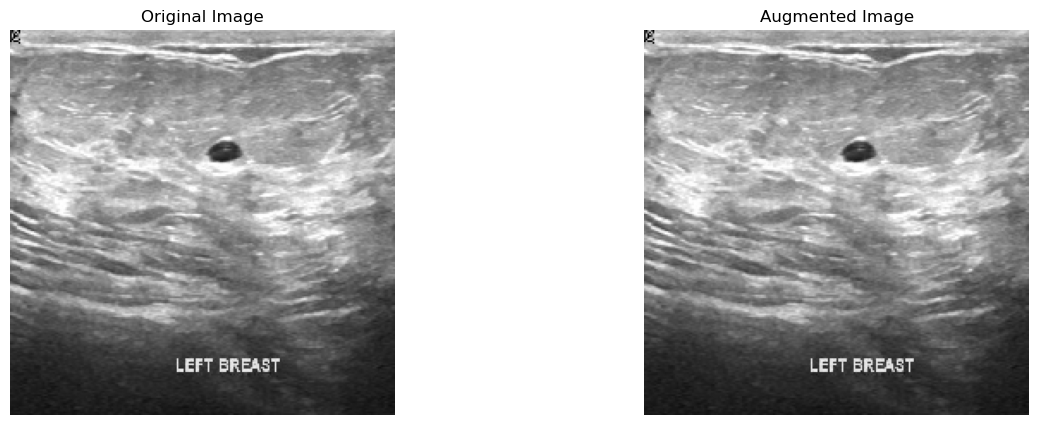

In [17]:
import matplotlib.pyplot as plt

# Function to display images
def display_images(images, titles):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for i in range(len(images)):
        axs[i].imshow(images[i])
        axs[i].set_title(titles[i])
        axs[i].axis("off")
    plt.show()

# Load an example image before augmentation
img_path = df['File Path'].iloc[0]
original_img = image.load_img(img_path, target_size=(224, 224))

# Apply augmentation to the original image
augmented_img = augment_image(np.array(original_img))

# Display the images
display_images([original_img, augmented_img], ["Original Image", "Augmented Image"])


In [18]:
#vgg 16
#CNN
#unet
#Resnet50
#svm\
#random forest


In [19]:
#from PIL import Image


# Task 5


In [20]:
#CNN
#Defining Tranformation and Augmentation function
from torchvision import transforms


# Define the minority classes in your dataset
class_names = ['malignant', 'normal','benign']
minority_classes = ['malignant', 'normal']

# Define custom data transformations for minority classes
minority_class_transforms = transforms.Compose([
    RandomHorizontalFlip(p=0.9),  # Apply with 90% probability
    RandomRotation(15, expand=False, center=None),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

# Define data transformations for train, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # Apply custom augmentations to minority classes
        transforms.RandomApply([minority_class_transforms], p=0.5) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#pip install torchvision

In [21]:
#Approach 1 - Data Split and create folders- excludes mask files
# Set the path to your input folder
data_dir =  os.path.join(current_directory, "Dataset_BUSI_with_GT")
# Create a list to store file paths and labels
file_paths = []
labels = []

# Loop through the subdirectories (benign, malignant, normal)
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            if image_file.endswith('.png') and not (image_file.endswith('_mask.png') or 
                                                     image_file.endswith('_mask_1.png') or
                                                     image_file.endswith('_mask_2.png')):
                image_path = os.path.join(label_dir, image_file)
                labels.append(label)
                file_paths.append(image_path)

# Create a DataFrame to store the file paths and labels
data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

# Split the dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.15, random_state=42, stratify=data['Label'])
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42, stratify=train_data['Label'])

# Define the paths for the train, validation, and test directories
train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/validation'
test_dir = '/kaggle/working/test'

# Create the train, validation, and test directories and subdirectories
for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

# Copy the images to the corresponding directories
for _, row in train_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(train_dir, label))

for _, row in val_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(val_dir, label))

for _, row in test_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(test_dir, label))

In [22]:
train_dir = '/kaggle/working/train'

# List the subdirectories (benign, malignant, normal)
subdirectories = ['benign', 'malignant', 'normal']

# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(train_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
   # print("Train folder counts including masks:")
    print(f"Train {category}: {count}")

validation_dir = '/kaggle/working/validation'

# List the subdirectories (benign, malignant, normal)
subdirectories = ['benign', 'malignant', 'normal']

# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(validation_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
    #print("Validation folder counts including masks:")
    print(f"Validation {category}: {count}")

test_dir = '/kaggle/working/test'

# List the subdirectories (benign, malignant, normal)
subdirectories = ['benign', 'malignant', 'normal']

# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(test_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
    #print("test folder counts including masks:")
    print(f"test {category}: {count}")

Train benign: 315
Train malignant: 152
Train normal: 96
Validation benign: 56
Validation malignant: 27
Validation normal: 17
test benign: 66
test malignant: 31
test normal: 20


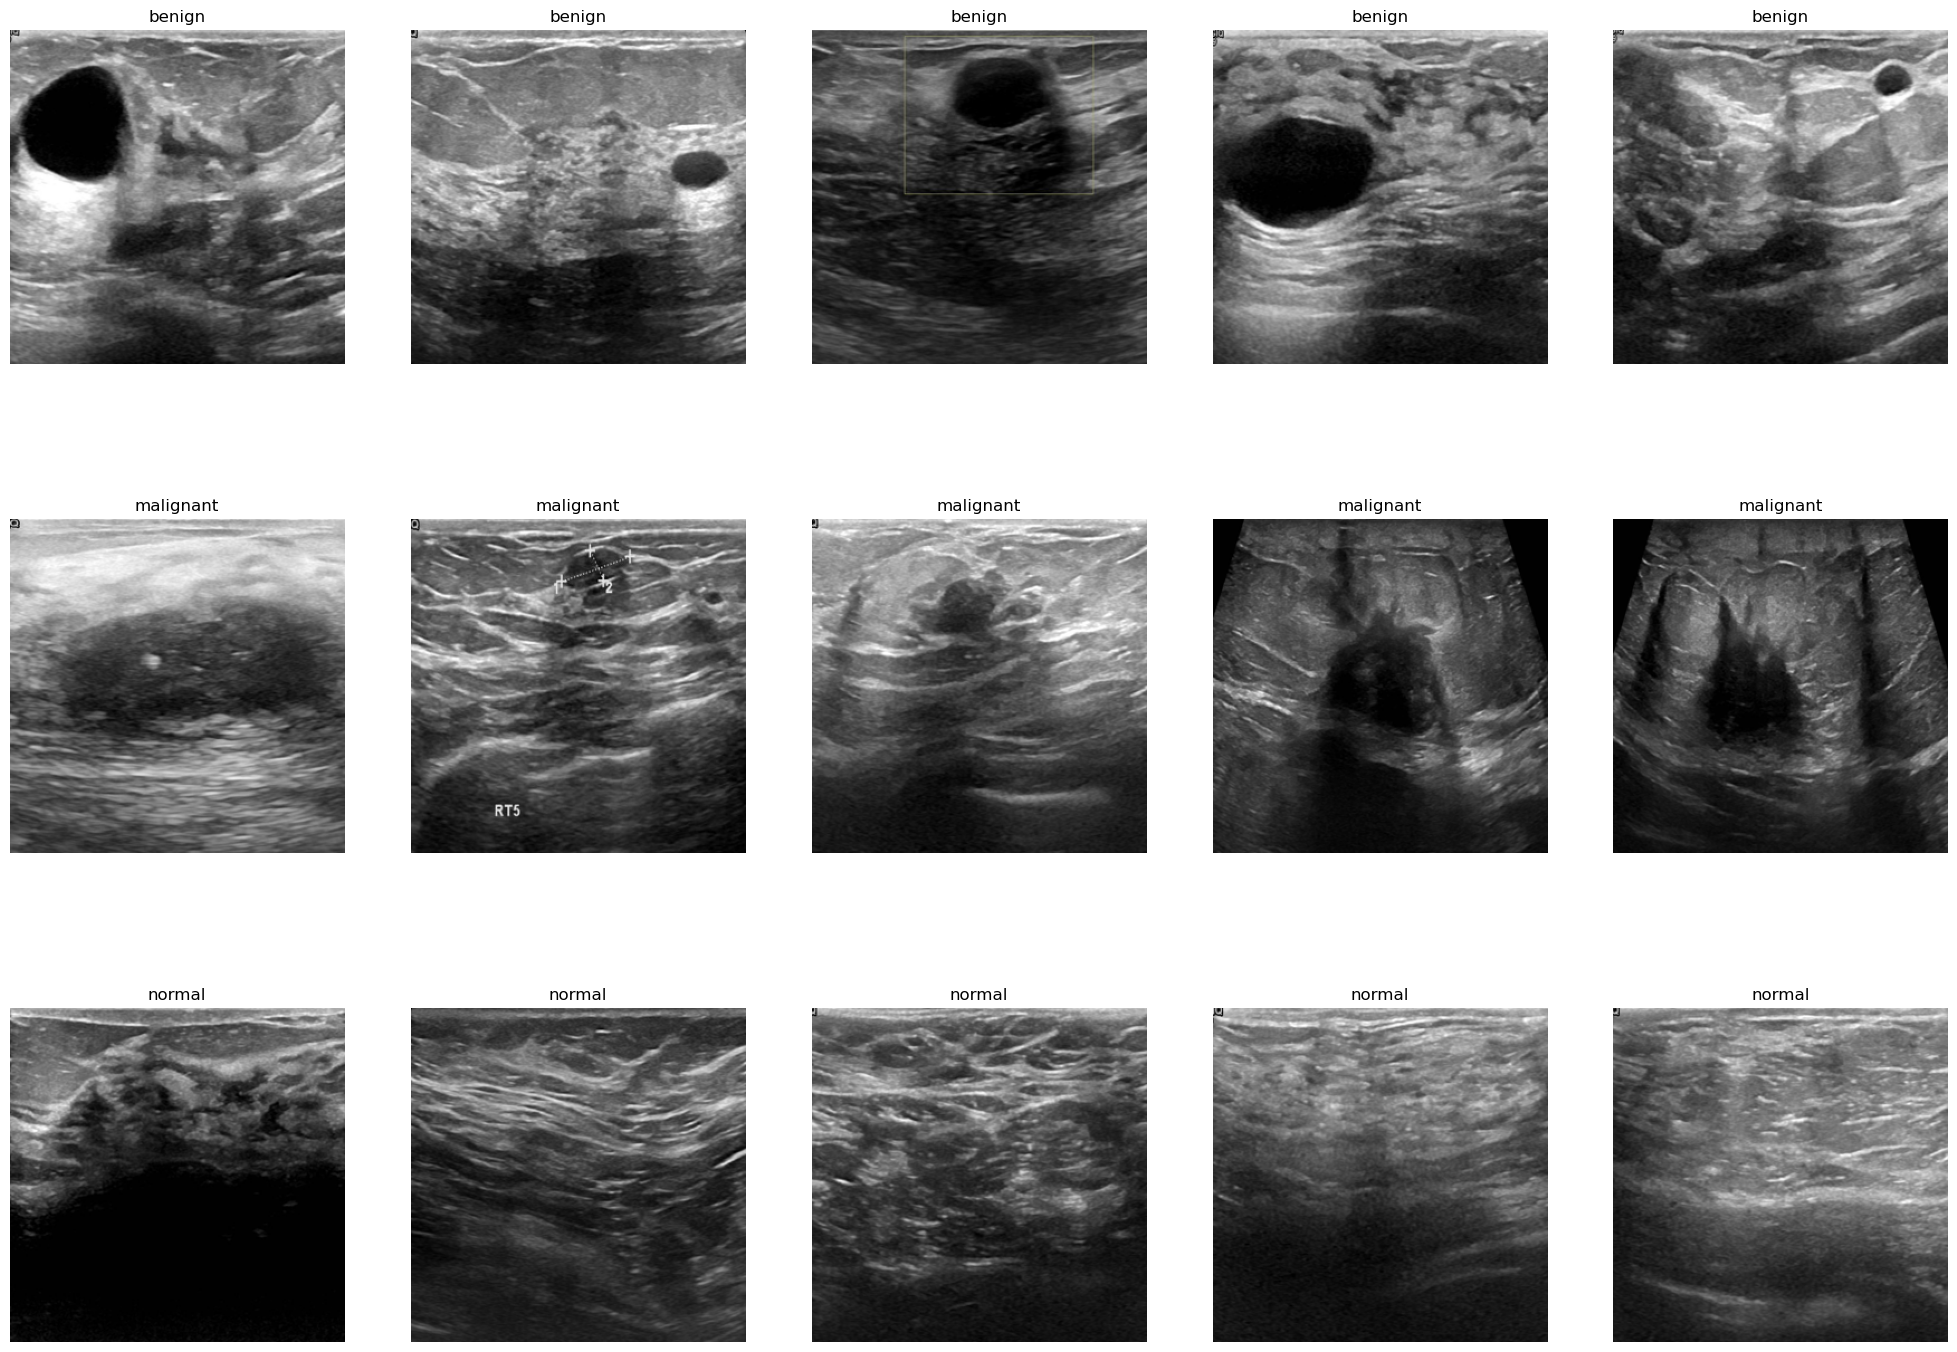

In [23]:
# Resize the image to the desired width and height
# Resize the image to the desired width and height
#image = image.resize((desired_width, desired_height))


# Define the paths to the train directory
train_dir = '/kaggle/working/train'

# Create subdirectories for each label
labels = ['benign', 'malignant', 'normal']
label_dirs = [os.path.join(train_dir, label) for label in labels]

# Create a figure to display the images
fig, axs = plt.subplots(3, 5, figsize=(25, 18))

# Desired width and height for each image
desired_width = 300  # Adjust as needed
desired_height = 300  # Adjust as needed

# Loop through each label and display 5 images
for i, label_dir in enumerate(label_dirs):
    # Get a list of image files (excluding mask files)
    images = [img for img in os.listdir(label_dir) if not img.endswith('_mask.png')][:5]

    for j, image_filename in enumerate(images):
        image_path = os.path.join(label_dir, image_filename)
        img = Image.open(image_path)
        
        # Resize the image to the desired width and height
        img = img.resize((desired_width, desired_height))
        
        # Display the image in the subplot
        axs[i, j].imshow(img)
        axs[i, j].set_title(labels[i])
        axs[i, j].axis('off')

plt.show()


In [24]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


data_dir = '/kaggle/working/'

# Create datasets for train, validation, and test
image_datasets = {
    x: ImageFolder(
        root=os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in ['train', 'validation', 'test']
}

# Specify batch size for dataloaders
batch_size = 8  # You can adjust this based on your hardware and preferences

# Create dataloaders for train, validation, and test
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'validation', 'test']}

# Calculate dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

# Get class labels
class_names = image_datasets['train'].classes

# Print dataset sizes and class labels
print("Dataset Sizes:", dataset_sizes)
print("Class Labels:", class_names)


Dataset Sizes: {'train': 563, 'validation': 100, 'test': 117}
Class Labels: ['benign', 'malignant', 'normal']


In [26]:
from torchvision import models
import time
import copy
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import models 

import torch
#Approach 1 -Model Set up/Initialize
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#Define training function - To be used for both approaches
# Define the training function with early stopping and additional features
def train_model_with_early_stopping(model, lossFunction, optimizer, scheduler, dataloaders, dataset_sizes, class_names, device, num_epochs=20, patience=2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')  # Initialize best_loss with a large value
    consecutive_epochs_without_improvement = 0

    # Lists to store training and validation losses
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = lossFunction(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Append training loss here
                if phase == 'train':
                    train_losses.append(loss.item())  # Append training loss
                else:
                    val_losses.append(loss.item())  # Append validation loss

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Early stopping: Check if validation loss improved
            if phase == 'validation':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    consecutive_epochs_without_improvement = 0
                else:
                    consecutive_epochs_without_improvement += 1


                val_losses.append(epoch_loss)

        # Check if early stopping criteria are met
        if consecutive_epochs_without_improvement >= patience:
            print(f"Early stopping after {epoch} epochs")
            break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:.4f}'.format(best_loss))
   
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    # Calculate classification report and confusion matrix for validation data
    y_true = []
    y_pred = []

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for inputs, labels in dataloaders['validation']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate classification report
    target_names = [str(class_names[i]) for i in range(len(class_names))]
    print(classification_report(y_true, y_pred, target_names=target_names))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    return model

#Transfer Learning by fineTuning the pretrained Resnet101 Model
#Load Resnet101 pretained Model
#Resnet101 = models.resnet101(pretrained=True)
#If pretained is not working, you can also use weights instead.
Resnet101 = models.resnet101(weights=True)

print(Resnet101)
#Set the resnet param.requires_grad = True to calculate the gradient,
#so that model fine-tunes the weights of the pretrained network
#by continuing the backpropagation.
for param in Resnet101.parameters():
    param.requires_grad = True

#Get the number of Input features of Resnet last fully connected layer
#because we are going to replace it with new fully connected layer.
in_features = Resnet101.fc.in_features

#Reset the final fully connected layer of the of the pre-trained Resnet.
Resnet101.fc = nn.Linear(in_features, len(class_names))

Resnet_fineTuning = Resnet101.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
import torch.optim as optim 
from torch.optim import lr_scheduler 
#Define optimzation algorithm
optimizer = optim.Adam(Resnet_fineTuning.parameters(), lr=0.00005)

# Decay LR by a factor of 0.1 every 7 epochs
Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#Define loss functions
Loss_Function = nn.CrossEntropyLoss()

In [28]:
#Approach 1 - Fine Tuning and training
model_fineTuning = train_model_with_early_stopping(
    Resnet_fineTuning, Loss_Function, optimizer, Decay_Learning_Rate, 
    dataloaders, dataset_sizes, class_names, device,num_epochs=20, patience=2)
torch.save(model_fineTuning, "/kaggle/working/Resnet_fineTuning.pth")

Epoch 0/19
----------
train Loss: 0.7900 Acc: 0.6341
validation Loss: 0.5567 Acc: 0.7600

Epoch 1/19
----------
train Loss: 0.5216 Acc: 0.7993
validation Loss: 0.4418 Acc: 0.8200

Epoch 2/19
----------
train Loss: 0.3731 Acc: 0.8597
validation Loss: 0.4924 Acc: 0.8000

Epoch 3/19
----------
train Loss: 0.3046 Acc: 0.8934
validation Loss: 0.5646 Acc: 0.8000
Early stopping after 3 epochs
Training complete in 19m 10s
Best val Loss: 0.4418
              precision    recall  f1-score   support

      benign       0.87      0.82      0.84        56
   malignant       0.77      0.85      0.81        27
      normal       0.76      0.76      0.76        17

    accuracy                           0.82       100
   macro avg       0.80      0.81      0.81       100
weighted avg       0.82      0.82      0.82       100

Confusion Matrix:
[[46  7  3]
 [ 3 23  1]
 [ 4  0 13]]


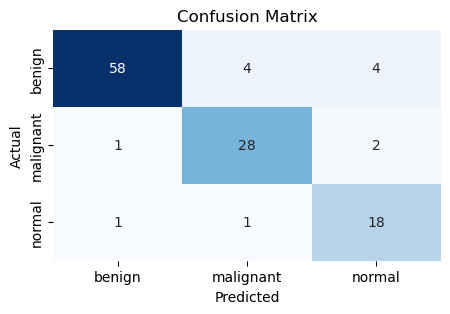

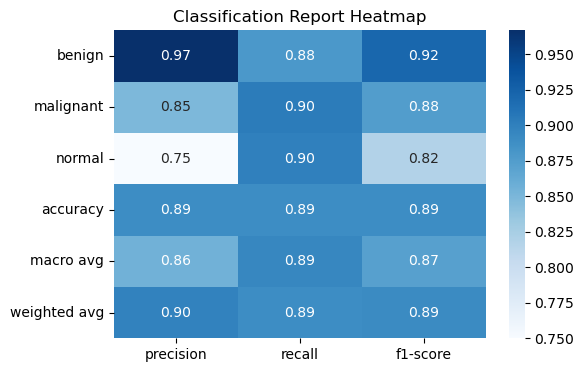

Simplified Classification Report:
             benign  malignant    normal  accuracy  macro avg  weighted avg
precision  0.966667   0.848485  0.750000  0.888889   0.855051      0.898316
recall     0.878788   0.903226  0.900000  0.888889   0.894005      0.888889
f1-score   0.920635   0.875000  0.818182  0.888889   0.871272      0.891030


In [29]:
#Approach 1 - Model Evaluation - Using ultrasound image files only
# Define label names
label_names = [str(class_names[i]) for i in range(len(class_names))]

# Calculate classification report and confusion matrix on unseen test data
y_true = []
y_pred = []

model_fineTuning.eval()  # Set model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_fineTuning(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Generate classification report
classification_rep = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)

# Generate confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with label names
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Convert the classification report to a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(classification_rep).iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')  # Simplify classification report
plt.title('Classification Report Heatmap')
plt.show()

# Print the simplified classification report
print("Simplified Classification Report:")
print(pd.DataFrame(classification_rep).iloc[:-1, :])  # Display without support and avg/total rows

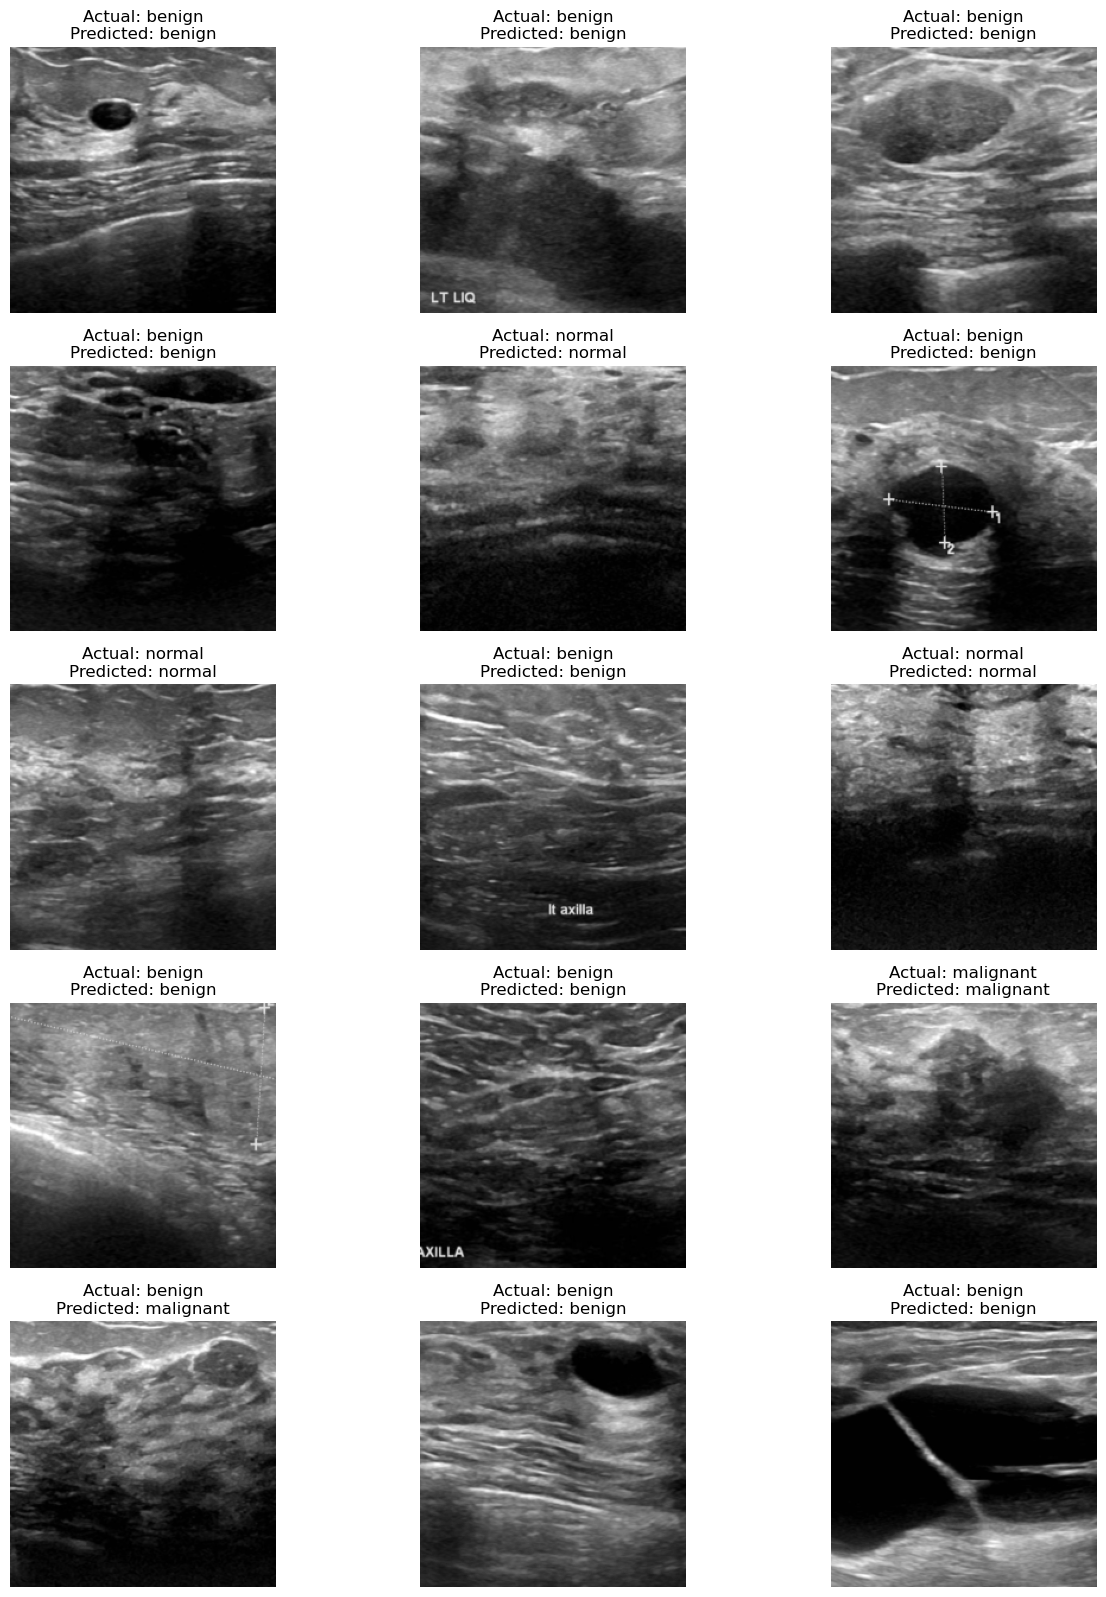

In [30]:
#Approach 1 - Visualizing results on few samples- Actual vs Prediction
import numpy as np
import matplotlib.pyplot as plt

# Set the number of images to display
num_images_to_display = 15

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(image_datasets['test'], batch_size=num_images_to_display, shuffle=True, num_workers=4)

# Get a batch of test data
inputs, labels = next(iter(test_dataloader))

# Move inputs to the device
inputs = inputs.to(device)

# Convert images to grayscale
grayscale_images = inputs.cpu().numpy().mean(axis=1)  # Convert RGB to grayscale

# Get model predictions
with torch.no_grad():
    model_fineTuning.eval()
    outputs = model_fineTuning(inputs)
    _, preds = torch.max(outputs, 1)

# Plot the grayscale images with labels and predictions
plt.figure(figsize=(15, 20))  # Increase the height to accommodate 5 rows
for i in range(num_images_to_display):
    ax = plt.subplot(5, 3, i + 1)  # Adjust the layout to 5 rows by 3 columns
    ax.axis('off')
    ax.set_title(f'Actual: {class_names[labels[i]]}\nPredicted: {class_names[preds[i]]}')
    plt.imshow(grayscale_images[i], cmap='gray')  # Display the grayscale image

plt.show()

In [ ]:
#Image Segmentation UNet

In [48]:

# benign_path = r'C:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_GT\benign'
# malignant_path = r'C:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_GT\malignant'
# normal_path = r'C:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_GT\normal'

# benign_df = os.listdir(benign_path)
# malignant_df = os.listdir(malignant_path)
# normal_df = os.listdir(normal_path)

# # print(f'\033[92m')
# # print(f"'normal' class has {len([i for i in normal_df if 'normal' in i and 'mask' not in i])} images and {len([i for i in normal_df if 'normal' in i and 'mask' in i])} masks.")
# # print(f"'benign' class has {len([i for i in benign_df if 'benign' in i and 'mask' not in i])} images and {len([i for i in benign_df if 'benign' in i and 'mask' in i])} masks.")
# # print(f"'malignant' class has {len([i for i in malignant_df if 'malignant' in i and 'mask' not in i])} images and {len([i for i in malignant_df if 'malignant' in i and 'mask' in i])} masks.")
# # print(f"\nThere are a total of {len([i for i in benign_df + malignant_df + normal_df if 'mask' not in i])} images and {len([i for i in benign_df + malignant_df + normal_df if 'mask' in i])} masks.")




# # paths =  r'C:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_GT' #file_paths
# # # DIRECTORY = os.path.join(file_paths, "Dataset_BUSI_with_GT")
# # # paths = glob(DIRECTORY)

# # #print(f"\nThere are total of {len([i for i in paths if 'mask' not in i])} images and {len([i for i in paths if 'mask' in i and i.endswith('.png')])} masks.")
# # # Print paths of files containing 'mask'
# # mask_paths = [i for i in paths if 'mask' in i]
# # print(mask_paths)

# # print(f'\033[92m')
# # print(f"'normal' class has {len([i for i in paths if 'normal' in i and 'mask' not in i])} images and {len([i for i in paths if 'normal' in i and 'mask' in i])} masks.")
# # print(f"'benign' class has {len([i for i in paths if 'benign' in i and 'mask' not in i])} images and {len([i for i in paths if 'benign' in i and 'mask' in i])} masks.")
# # print(f"'malignant' class has {len([i for i in paths if 'malignant' in i and 'mask' not in i])} images and {len([i for i in paths if 'malignant' in i and 'mask' in i])} masks.")
# # print(f"\nThere are total of {len([i for i in paths if 'mask' not in i])} images and {len([i for i in paths if 'mask' in i])} masks.")



# # benign_path = r'C:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_GT\benign'
# # malignant_path = r'C:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_GT\malignant'
# # normal_path = r'C:\Users\bhakt\KDD\Project4\Dataset_BUSI_with_GT\normal'

# # benign_df = os.listdir(benign_path)
# # malignant_df = os.listdir(malignant_path)
# # normal_df = os.listdir(normal_path)

# # # Create a list of paths using glob
# # paths = glob(os.path.join('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT', '*', '*'))

# # print(f'\033[92m')
# # print(f"'normal' class has {len([i for i in normal_df if 'normal' in i and 'mask' not in i])} images and {len([i for i in normal_df if 'normal' in i and 'mask' in i])} masks.")
# # print(f"'benign' class has {len([i for i in benign_df if 'benign' in i and 'mask' not in i])} images and {len([i for i in benign_df if 'benign' in i and 'mask' in i])} masks.")
# # print(f"'malignant' class has {len([i for i in malignant_df if 'malignant' in i and 'mask' not in i])} images and {len([i for i in malignant_df if 'malignant' in i and 'mask' in i])} masks.")
# # print(f"\nThere are a total of {len([i for i in benign_df + malignant_df + normal_df if 'mask' not in i])} images and {len([i for i in benign_df + malignant_df + normal_df if 'mask' in i])} masks.")
import glob

base_path = os.getcwd()

benign_path = os.path.join(base_path, 'Dataset_BUSI_with_GT', 'benign')
malignant_path = os.path.join(base_path, 'Dataset_BUSI_with_GT', 'malignant')
normal_path = os.path.join(base_path, 'Dataset_BUSI_with_GT', 'normal')

benign_df = os.listdir(benign_path)
malignant_df = os.listdir(malignant_path)
normal_df = os.listdir(normal_path)

# Extract the root folder name
root_folder = os.path.basename(base_path)

paths = glob.glob(os.path.join(base_path, 'Dataset_BUSI_with_GT', '*', '*'))


print(f'\033[92m')
print(f"'normal' class has {len([i for i in normal_df if 'normal' in i and 'mask' not in i])} images and {len([i for i in normal_df if 'normal' in i and 'mask' in i])} masks.")
print(f"'benign' class has {len([i for i in benign_df if 'benign' in i and 'mask' not in i])} images and {len([i for i in benign_df if 'benign' in i and 'mask' in i])} masks.")
print(f"'malignant' class has {len([i for i in malignant_df if 'malignant' in i and 'mask' not in i])} images and {len([i for i in malignant_df if 'malignant' in i and 'mask' in i])} masks.")
print(f"\nThere are a total of {len([i for i in benign_df + malignant_df + normal_df if 'mask' not in i])} images and {len([i for i in benign_df + malignant_df + normal_df if 'mask' in i])} masks.")


'normal' class has 133 images and 133 masks.
'benign' class has 437 images and 454 masks.
'malignant' class has 210 images and 211 masks.

There are a total of 780 images and 798 masks.


In [54]:
def load_image(path, size):
    image = cv2.imread(path)
    image = cv2.resize(image, (size,size))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)   # shape: (size,size,3) -> (size,size,1)
    image = image/255.   # normalize
    return image

def load_data(root_path, size):
    images = []
    masks = []
    
    x = 0   # additional variable to identify images consisting of 2 or more masks
    
    for path in sorted(glob.glob(root_path)):
        img = load_image(path, size)   # read mask or image
            
        if 'mask' in path:
            if x:   # this image has masks more than one
                masks[-1] += img   # add the mask to the last mask
                    
                # When 2 masks are added, the range can increase by 0-2. So we will reduce it again to the range 0-1.
                masks[-1] = np.array(masks[-1]>0.5, dtype='float64')
            else:
                masks.append(img)
                x = 1   # if the image has a mask again, the above code will run next time
        else:
            images.append(img)
            x = 0   # for moving to the next image
    return np.array(images), np.array(masks)

In [55]:


size = 128   # image size: 128x128
# Get the current working directory
root_path = os.getcwd()

# Modify the line to call load_data function
X, y = load_data(root_path=os.path.join(base_path, 'Dataset_BUSI_with_GT', '*', '*'), size=size)


In [56]:
# drop normal class because normal class has not mask
X = X[:647]
y = y[:647]

print(f"X shape: {X.shape}     |  y shape: {y.shape}")

# prepare data to modeling
X = np.expand_dims(X, -1)
y = np.expand_dims(y, -1)

print(f"\nX shape: {X.shape}  |  y shape: {y.shape}")

X shape: (647, 128, 128)     |  y shape: (647, 128, 128)

X shape: (647, 128, 128, 1)  |  y shape: (647, 128, 128, 1)


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)

print(f'\033[92m')
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)


X_train shape: (194, 128, 128, 1)
y_train shape: (194, 128, 128, 1)
X_test shape: (453, 128, 128, 1)
y_test shape: (453, 128, 128, 1)


In [58]:
#Building U-Net Architecture
def conv_block(input, num_filters):
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(input)
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
    return conv


In [59]:
def encoder_block(input, num_filters):
    conv = conv_block(input, num_filters)
    pool = MaxPooling2D((2, 2))(conv)
    return conv, pool

In [60]:
def decoder_block(input, skip_features, num_filters):
    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters)
    return conv

In [68]:



def build_model(input_shape):
    input_layer = Input(input_shape)
    
    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    output_layer = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    
    model_unet = Model(input_layer, output_layer, name="U-Net")
    return model_unet

model_unet = build_model(input_shape=(size, size, 1))
model_unet.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [69]:
history = model_unet.fit(X_train, y_train, epochs = 100, validation_data = (X_test,y_test))




Epoch 1/100


7/7 [==============================] - 101s 15s/step - loss: 0.5178 - accuracy: 0.8866 - val_loss: 0.3547 - val_accuracy: 0.9025
Epoch 2/100
7/7 [==============================] - 79s 12s/step - loss: 2.9299 - accuracy: 0.7680 - val_loss: 0.3878 - val_accuracy: 0.9025
Epoch 3/100
7/7 [==============================] - 98s 15s/step - loss: 0.3722 - accuracy: 0.9086 - val_loss: 0.3680 - val_accuracy: 0.9025
Epoch 4/100
7/7 [==============================] - 87s 13s/step - loss: 0.3380 - accuracy: 0.9086 - val_loss: 1.0421 - val_accuracy: 0.9025
Epoch 5/100
7/7 [==============================] - 162s 25s/step - loss: 0.4835 - accuracy: 0.9086 - val_loss: 0.3443 - val_accuracy: 0.9025
Epoch 6/100
7/7 [==============================] - 144s 22s/step - loss: 0.3410 - accuracy: 0.9086 - val_loss: 0.3308 - val_accuracy: 0.9025
Epoch 7/100
7/7 [==============================] - 79s 12s/step - loss: 0.3297 - accuracy: 0.9086 - val_loss: 0.3274 - val_accuracy: 0.9025
Epoch 8/100
7/7

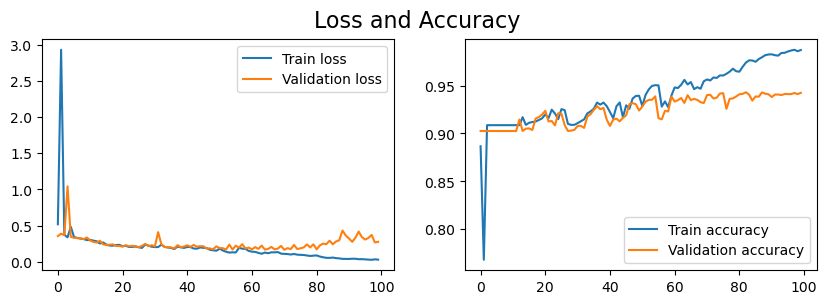

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

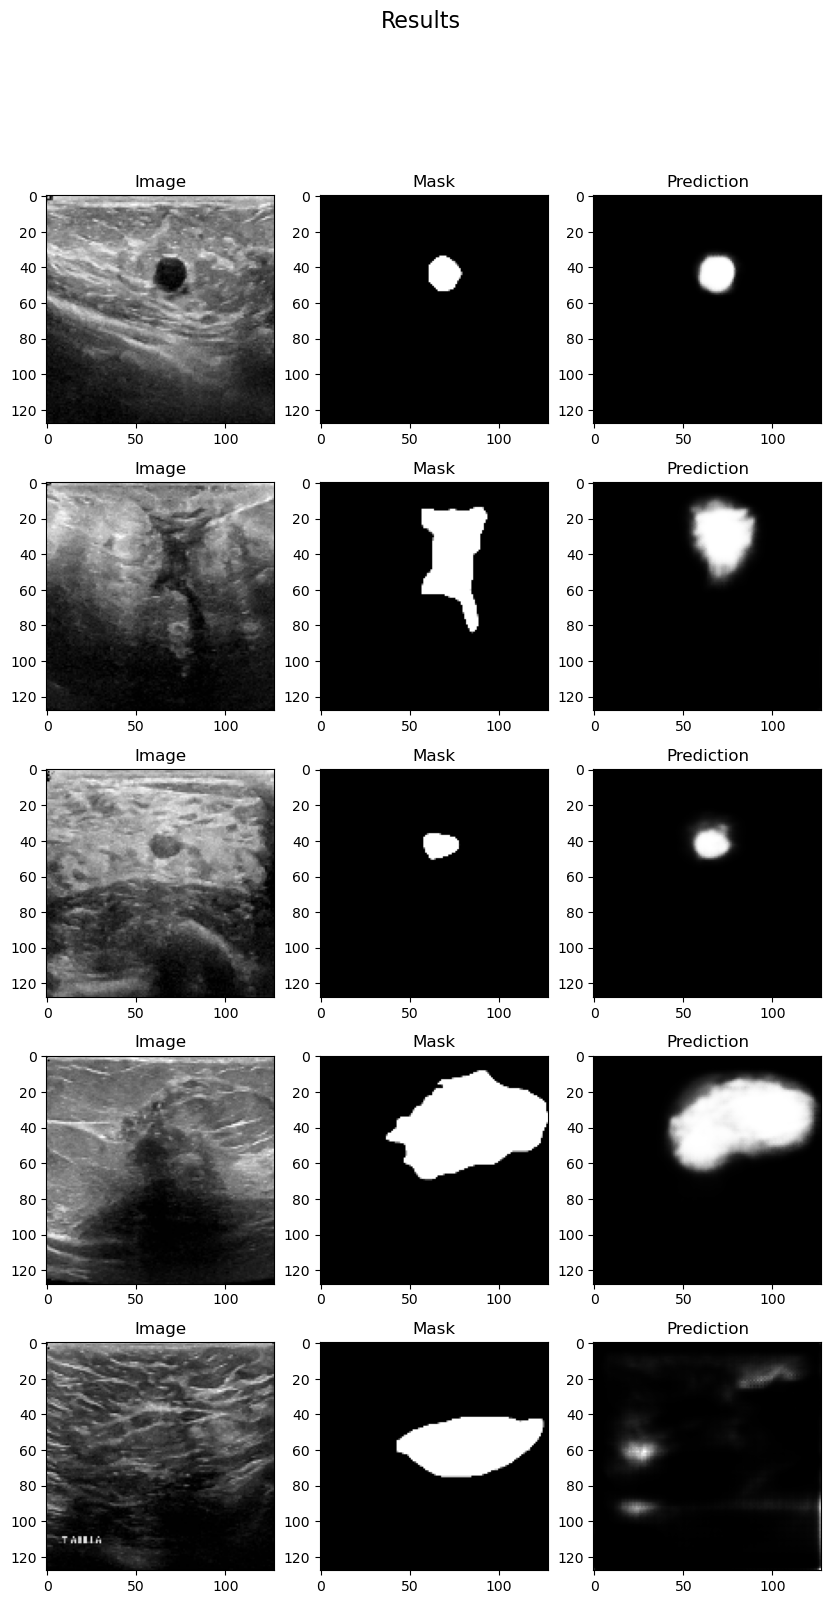

In [71]:
#Evaluation
fig, ax = plt.subplots(5,3, figsize=(10,18))

j = np.random.randint(0, X_test.shape[0], 5)
for i in range(5):
    ax[i,0].imshow(X_test[j[i]], cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].imshow(y_test[j[i]], cmap='gray')
    ax[i,1].set_title('Mask')
    ax[i,2].imshow(model_unet.predict(np.expand_dims(X_test[j[i]],0),verbose=0)[0], cmap='gray')
    ax[i,2].set_title('Prediction')
fig.suptitle('Results', fontsize=16)
plt.show()


In [74]:
from keras.metrics import MeanIoU,Precision,Recall



print(f'\033[93m')
y_pred=model_unet.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)


Mean IoU = 0.72694445
Precision Score = 0.616
Recall Score = 0.755
F1 Score = 0.678


In [78]:
#resnet50
# images = []
# for path in paths:
#     masks = glob.glob(os.path.join(path, '*_mask.png'))
#     for mask in masks:
#         images.append(mask.replace('_mask', ''))


In [86]:
# import os

# # Get the current working directory
# current_directory = os.getcwd()

# # Update the path to use the current directory
# mask_pattern = os.path.join(current_directory, 'Dataset_BUSI_with_GT', '*', '*_mask.png')

# # Use the updated path
# mask_paths = glob.glob(mask_pattern)

# # Now 'mask_paths' contains the paths in the current working directory
# #print(mask_paths)

# images = []
# #mask = glob.glob("/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/*/*_mask.png")
# for i in mask_paths:
#     images.append(i.replace('_mask',''))



In [88]:
# print(images[:5])
# print('-------------------')
# print(mask_paths[:5])

['c:\\Users\\bhakt\\KDD\\Project4\\Dataset_BUSI_with_GT\\benign\\benign (1).png', 'c:\\Users\\bhakt\\KDD\\Project4\\Dataset_BUSI_with_GT\\benign\\benign (10).png', 'c:\\Users\\bhakt\\KDD\\Project4\\Dataset_BUSI_with_GT\\benign\\benign (100).png', 'c:\\Users\\bhakt\\KDD\\Project4\\Dataset_BUSI_with_GT\\benign\\benign (101).png', 'c:\\Users\\bhakt\\KDD\\Project4\\Dataset_BUSI_with_GT\\benign\\benign (102).png']
-------------------
['c:\\Users\\bhakt\\KDD\\Project4\\Dataset_BUSI_with_GT\\benign\\benign (1)_mask.png', 'c:\\Users\\bhakt\\KDD\\Project4\\Dataset_BUSI_with_GT\\benign\\benign (10)_mask.png', 'c:\\Users\\bhakt\\KDD\\Project4\\Dataset_BUSI_with_GT\\benign\\benign (100)_mask.png', 'c:\\Users\\bhakt\\KDD\\Project4\\Dataset_BUSI_with_GT\\benign\\benign (101)_mask.png', 'c:\\Users\\bhakt\\KDD\\Project4\\Dataset_BUSI_with_GT\\benign\\benign (102)_mask.png']


In [91]:
# data = pd.DataFrame({'images':images,'masks':mask_paths})
# data.head(9)
# data.shape


(780, 2)

In [92]:
# data_train,data_test=train_test_split(data,test_size=0.1)

# data_train,data_val=train_test_split(data_train,test_size=0.1)

In [93]:
# datagen = ImageDataGenerator(rotation_range=0.2,
#                             width_shift_range=0.05,
#                             height_shift_range=0.05,
#                             shear_range=0.05,
#                             zoom_range=0.05,
#                             horizontal_flip=True,
#                             fill_mode='nearest',
#                             rescale=1./255)

In [94]:
# image_train=datagen.flow_from_dataframe(data_train,  
#                                     target_size=(512,512), 
#                                     color_mode='rgb',
#                                     shuffle=True,
#                                     seed=123,
#                                     x_col ="images", 
#                                     batch_size=8,
#                                     class_mode=None
                                    
# )
# mask_train=datagen.flow_from_dataframe(data_train, 
#                                     target_size=(512,512), 
#                                     color_mode='grayscale',
#                                     shuffle=True,
#                                     seed=123,
#                                     x_col ="masks", 
#                                     batch_size=8,
#                                     class_mode=None
# )

Found 631 validated image filenames.
Found 631 validated image filenames.


In [95]:
# image_validation=datagen.flow_from_dataframe(data_val,  
#                                     target_size=(512,512), 
#                                     color_mode='rgb',
#                                     shuffle=True,
#                                     seed=123,
#                                     x_col ="images", 
#                                     batch_size=8,
#                                     class_mode=None
# )

# mask_validation=datagen.flow_from_dataframe(data_val, 
#                                     target_size=(512,512), 
#                                     color_mode='grayscale',
#                                     shuffle=True,
#                                     seed=123,
#                                     x_col ="masks", 
#                                     batch_size=8,
#                                     class_mode=None
# )

Found 71 validated image filenames.
Found 71 validated image filenames.


In [96]:
# train_gen=zip(image_train,mask_train)
# valid_gen=zip(image_validation,mask_validation)

In [97]:
# from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
# from tensorflow.keras.models import Model
# from tensorflow.keras.applications import ResNet50

# def conv_block(inputs, num_filters):
#     x = Conv2D(num_filters, 3, padding="same")(inputs)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)
    
#     x = Conv2D(num_filters, 3, padding="same")(x)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)
    
#     return x

In [98]:
# def decoder_block(inputs, skip_features, num_filters):
#     x = Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(inputs)
#     x = Concatenate()([x, skip_features])
#     x = conv_block(x, num_filters)
#     return x

In [137]:
import pathlib

#ANN
#Preprocessing
class readDataset:
    def __init__(self, datasetpath, imageShape):
        self.datasetpath = datasetpath
        self.imageShape = imageShape
    def imagesPath(self, folder, name):
        images = list(pathlib.Path(os.path.join(self.datasetpath, 
                                                folder)).glob('*{}.*'.format(name)))
        return images
    def readImages(self, images, channels):
        listImages = []
        images = np.sort(images)
        for image in images:
            image = tf.io.read_file(str(image))
            image = tf.image.decode_png(image, channels = channels)
            image = tf.image.resize(image, self.imageShape)
            image/= 255
            listImages.append(image)
        return listImages
    def allDataset(self, label):
        images = self.readImages(self.imagesPath(label, name = ')'), channels = 3)
        masks = np.array(self.readImages(self.imagesPath(label, name = 'mask'), channels = 1))
        masks = (masks >= 0.5).astype('int32')
        return np.array(images), masks
    def finalDataset(self, labels):
        images_benign, masks_benign = self.allDataset(labels[0])
        images_malignant, masks_malignant = self.allDataset(labels[1])
        images_normal, masks_normal = self.allDataset(labels[2])
        images = np.vstack([images_benign, images_malignant, images_normal])
        masks = np.vstack([masks_benign, masks_malignant, masks_normal])
        labels = np.hstack([np.ones(shape = (len(images_benign),))*0,
                           np.ones(shape = (len(images_malignant), ))*1, 
                           np.ones(shape = (len(images_normal), ))*2])
        return images, masks, labels
    
    def dataAugmentation(self, images, masks, labels):
        imagesupdate = []
        masksupdate = []
        labelsupdate = []
        for image, mask, label in zip(images, labels, masks):
            image1 = tf.image.adjust_contrast(image, contrast_factor = 2)
            image2 = tf.image.adjust_brightness(image, delta = 0.3)
            imagesupdate.append(image), masksupdate.append(mask), labelsupdate.append(label)
            imagesupdate.append(image1), masksupdate.append(mask), labelsupdate.append(label)
            imagesupdate.append(image2), masksupdate.append(mask), labelsupdate.append(label)
        return np.array(imagesupdate), np.array(masksupdate), np.array(labelsupdate)




datasetpath = DIRECTORY #os.path.join(base_path, 'Dataset_BUSI_with_GT', '*', '*')
#'\KDD\Project4\Dataset_BUSI_with_GT'
datasetObject = readDataset(datasetpath, [128, 128])
images, masks, labels = datasetObject.finalDataset(['benign', 'malignant', 'normal'])

In [138]:
images, masks, labels = datasetObject.dataAugmentation(images, labels, masks)
images.shape, masks.shape, labels.shape

((2340, 128, 128, 3), (2340, 128, 128, 1), (2340,))

In [139]:
randomIndexs = np.random.randint(0, len(images), size = (len(images), ))
images = images[randomIndexs]
masks = masks[randomIndexs]
labels = labels[randomIndexs]
images.shape, masks.shape, labels.shape

((2340, 128, 128, 3), (2340, 128, 128, 1), (2340,))

In [140]:
valid = 500
trainDataset = [images[:images.shape[0] - valid], 
         masks[:images.shape[0] - valid], 
         labels[:images.shape[0] - valid]]
validDataset = [images[images.shape[0] - valid:], 
         masks[images.shape[0] - valid:], 
         labels[images.shape[0] - valid:]]

In [141]:
trainDataset[0].shape, trainDataset[1].shape, trainDataset[2].shape

((1840, 128, 128, 3), (1840, 128, 128, 1), (1840,))

In [142]:
validDataset[0].shape, validDataset[1].shape, validDataset[2].shape

((500, 128, 128, 3), (500, 128, 128, 1), (500,))

In [143]:
def convolution(inputs, padding, strides, filter, kernel_size):
    x = inputs
    y = layers.Conv2D(filter, kernel_size = 1, padding = padding, 
                     strides = strides, 
                     kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
    x = layers.Conv2D(filter, kernel_size = kernel_size, padding = padding, 
                     strides = strides, 
                     kernel_regularizer = tf.keras.regularizers.L2(0.001))(y)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filter, kernel_size = kernel_size, padding = padding, 
                     strides = strides, 
                     kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, y])
    x = layers.Activation('relu')(x)
    return x

In [144]:
def encoder(inputs, filter):
    correlation = convolution(inputs, padding = 'same', strides = 1, filter = filter, 
                             kernel_size = 5)
    downsample = layers.AveragePooling2D()(correlation)
    return correlation, downsample

In [145]:
def decoder(inputs, skip_connection, filter):
    upsample = layers.Conv2DTranspose(filter, 5, padding = 'same', strides = 2, 
                                     kernel_regularizer = tf.keras.regularizers.L2(0.001))(inputs)
    upsample = layers.Activation('relu')(upsample)
    upsample = layers.BatchNormalization()(upsample)
    connection = layers.average([upsample, skip_connection])
    correlation = convolution(connection, padding = 'same', strides = 1, filter = filter, 
                             kernel_size = 5)
    return correlation

In [153]:
from keras import layers
from keras import models
import tensorflow as tf




input = layers.Input(shape = (128, 128, 3))
filter = 32
corr1, downsample1 = encoder(input, filter)
corr2, downsample2 = encoder(downsample1, filter*2)
corr3, downsample3 = encoder(downsample2, filter*4)
corr4, downsample4 = encoder(downsample3, filter*8)
downsample4 = convolution(downsample4, padding = 'same', strides = 1, filter = filter*8, 
                         kernel_size = 5)
features_vector_1 = layers.GlobalAveragePooling2D()(downsample4)
features_vector_2 = layers.Flatten()(downsample4)
features_vector_2 = layers.Dropout(0.5)(features_vector_2)
features_vector_1 = layers.Dropout(0.5)(features_vector_1)
encoder_x = layers.Dense(64, name = 'latent_space', 
                kernel_regularizer = tf.keras.regularizers.L2(0.001))(features_vector_1)
x = layers.Dense(downsample4.shape[1]*downsample4.shape[2]*downsample4.shape[3], 
                kernel_regularizer = tf.keras.regularizers.L2(0.001))(encoder_x)
x = layers.Reshape((downsample4.shape[1], downsample4.shape[2], downsample4.shape[3]), 
                  name = 'reshape')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
decoder_corr1 = decoder(x, corr4, filter*8)
decoder_corr2 = decoder(decoder_corr1, corr3, filter*4)
decoder_corr3 = decoder(decoder_corr2, corr2, filter*2)
decoder_corr4 = decoder(decoder_corr3, corr1, filter)
output = layers.Conv2DTranspose(1, 5, padding = 'same', strides = 1)(decoder_corr4)
output = layers.Activation('sigmoid', name = 'ANN')(output)
labelOutput = layers.Dense(32, activation = 'relu')(features_vector_2)
labelOutput = layers.BatchNormalization()(labelOutput)
labelOutput = layers.Dropout(0.5)(labelOutput)
labelOutput = layers.Dense(16, activation = 'relu')(labelOutput)
labelOutput = layers.BatchNormalization()(labelOutput)
labelOutput = layers.Dropout(0.5)(labelOutput)
labelOutput = layers.Dense(1, name = 'label')(labelOutput)

m = models.Model(inputs = input, outputs = [output, labelOutput])

m.compile(loss = [tf.keras.losses.BinaryFocalCrossentropy(), 'mae'], 
          optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001), 
          metrics = ['accuracy', Precision(name = 'precision'), Recall(name = 'recall')], 
          )
m.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_103 (Conv2D)         (None, 128, 128, 32)         128       ['input_19[0][0]']            
                                                                                                  
 conv2d_104 (Conv2D)         (None, 128, 128, 32)         25632     ['conv2d_103[0][0]']          
                                                                                                  
 batch_normalization_50 (Ba  (None, 128, 128, 32)         128       ['conv2d_104[0][0]']          
 tchNormalization)                                                                          

In [150]:
#pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [154]:
tf.keras.utils.plot_model(m,
                            show_shapes=True,
                            show_layer_names=True,)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [155]:
history = m.fit(trainDataset[0], [trainDataset[1], trainDataset[2]], epochs = 260, 
               validation_data = (validDataset[0], [validDataset[1], validDataset[2]]), 
               batch_size = 8, callbacks = [
                   tf.keras.callbacks.EarlyStopping(patience = 12, monitor = 'val_loss', 
                                                   mode = 'min', restore_best_weights = True)
               ])

Epoch 1/260
230/230 [==============================] - 428s 2s/step - loss: 5.9213 - ANN_loss: 0.1430 - label_loss: 1.5980 - ANN_accuracy: 0.7689 - ANN_precision: 0.0799 - ANN_recall: 0.1836 - label_accuracy: 0.4701 - label_precision: 0.4199 - label_recall: 0.3819 - val_loss: 4.8047 - val_ANN_loss: 0.0951 - val_label_loss: 0.6228 - val_ANN_accuracy: 0.9167 - val_ANN_precision: 0.0110 - val_ANN_recall: 7.2981e-04 - val_label_accuracy: 0.5740 - val_label_precision: 0.3778 - val_label_recall: 0.0881
Epoch 2/260
230/230 [==============================] - 452s 2s/step - loss: 5.5948 - ANN_loss: 0.0723 - label_loss: 1.5407 - ANN_accuracy: 0.9134 - ANN_precision: 0.3166 - ANN_recall: 0.0855 - label_accuracy: 0.4641 - label_precision: 0.4229 - label_recall: 0.4068 - val_loss: 4.6196 - val_ANN_loss: 0.0604 - val_label_loss: 0.6798 - val_ANN_accuracy: 0.9250 - val_ANN_precision: 0.5699 - val_ANN_recall: 0.1703 - val_label_accuracy: 0.4260 - val_label_precision: 0.3911 - val_label_recall: 0.5026
